# Multiclass Classification of Cancer Using Gene Expression Data.
The Data for this case study is an RNA-sequence gene expression data for different Cancer Types.
The Columns represent the gene count values while the rows represent the samples.

## Required libraries for the case study:
- numpy
- matplotlib
- seaborn
- pandas
- scikit-learn

# import all the necessary libraries

In [1]:
import zipfile
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             balanced_accuracy_score, f1_score, precision_score, recall_score)

In [2]:
# Download and Load Data
file_url = "https://github.com/albertegi/Multiclass-Cancer-Classification-Using-Gene-Expression-Data/blob/main/cancer_gene_expression.zip?raw=true"
response = requests.get(file_url)
response.raise_for_status()
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('cancer_gene_expression.csv') as f:
        dataframe = pd.read_csv(f)

In [3]:
# Now `dataframe` should contain the data from the CSV file
print(dataframe.head())

   gene_1  gene_2  gene_3    gene_4  gene_5  gene_6  gene_7  gene_8    gene_9  \
0     0.0     0.0     0.0  2.088413     0.0     0.0     0.0     0.0  0.550605   
1     0.0     0.0     0.0  3.205955     0.0     0.0     0.0     0.0  0.425244   
2     0.0     0.0     0.0  4.746646     0.0     0.0     0.0     0.0  2.639417   
3     0.0     0.0     0.0  1.173191     0.0     0.0     0.0     0.0  1.527371   
4     0.0     0.0     0.0  1.366532     0.0     0.0     0.0     0.0  0.000000   

    gene_10  ...  gene_7992  gene_7993  gene_7994  gene_7995  gene_7996  \
0  2.815760  ...  11.558803   8.881802   6.014840   6.643534  11.740624   
1  2.354396  ...  11.062829   9.032864   5.054193   6.432320  12.104985   
2  1.657091  ...  12.497640   7.198160   0.943434   7.371690  11.202356   
3  2.732899  ...  11.261713   8.725676   6.300418   6.036451  11.732303   
4  3.388355  ...  12.241965   7.685204   5.142948   6.355788  11.493950   

   gene_7997  gene_7998  gene_7999  gene_8000  Cancer_Type  
0

# Data Exploration and Cleaning

In [4]:
# Check the number of features and samples in the dataset
# The last column contains the target variable
print(dataframe.shape)

(801, 8001)


In [5]:
# Check the first five columns in the dataset
print(dataframe.columns[0:5])

Index(['gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5'], dtype='object')


In [6]:
# Check the name of the last column: which is the target variable
dataframe.columns[-1]

'Cancer_Type'

In [7]:
#Check for missing values

data_null_values = dataframe.isnull().sum()
null_values = [data_null_value for data_null_value in data_null_values if data_null_value > 0]
print('Colums with missing values:%d'%len(null_values))

Colums with missing values:0


<Axes: ylabel='count'>

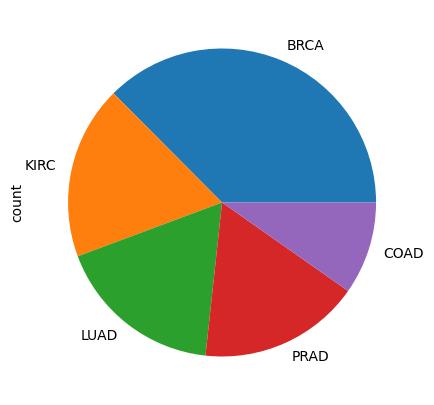

In [8]:
# plot a pie chat chat to display the class distribution

dataframe['Cancer_Type'].value_counts().plot(kind='pie', figsize=(10, 5))

In [9]:
# plot a bar chat chat to display the class distribution

dataframe['Cancer_Type'].value_counts().plot.bar

<bound method PlotAccessor.bar of <pandas.plotting._core.PlotAccessor object at 0x10b1a0a70>>

## Cancer Types
- BRCA - Breast Cancer
- KIRC - Kidney
- LUAD - Lung Cancer
- PRAD - Prostrate Cancer
- COAD - Colon Cancer

# Data preprocessing

This is to process making the data in a suitable format before modelling

In [10]:
# Encode Target Variable: 
# The target variable is categorical, and therefore need to be converted to numberic form.

# separate the features from the target variable.
X = dataframe.iloc[:, :-1]
y = dataframe.iloc[:, -1]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
labels = label_encoder.classes_
classes = np.unique(y_encoded)

In [11]:
X.shape

(801, 8000)

In [12]:
y.shape

(801,)

In [13]:
y_encoded

array([2, 2, 0, 2, 1, 3, 2, 3, 0, 1, 4, 0, 4, 4, 2, 4, 2, 3, 3, 4, 0, 1,
       0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 2, 4, 0, 0, 0, 4, 0, 0, 1, 0,
       3, 2, 1, 1, 2, 0, 4, 1, 0, 3, 3, 0, 3, 0, 0, 4, 3, 4, 0, 4, 3, 0,
       1, 2, 2, 0, 1, 1, 0, 4, 2, 0, 4, 3, 1, 2, 2, 3, 2, 0, 0, 0, 4, 3,
       0, 3, 4, 2, 0, 0, 0, 2, 4, 2, 0, 4, 3, 3, 2, 0, 0, 4, 0, 0, 0, 0,
       0, 2, 3, 2, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 3, 0, 0, 2, 0, 3, 0, 1, 4, 1, 3, 1, 3, 0, 1, 0, 0, 0,
       2, 1, 1, 3, 3, 4, 3, 0, 3, 2, 0, 2, 0, 3, 0, 3, 2, 2, 3, 0, 0, 0,
       3, 2, 1, 3, 0, 0, 3, 0, 4, 4, 3, 1, 0, 0, 0, 4, 1, 0, 4, 0, 4, 1,
       0, 4, 2, 4, 4, 0, 3, 0, 3, 0, 0, 2, 2, 3, 2, 3, 4, 0, 2, 3, 3, 1,
       3, 0, 4, 3, 0, 1, 3, 2, 4, 0, 0, 4, 3, 2, 4, 0, 4, 2, 0, 2, 3, 0,
       3, 0, 2, 4, 0, 2, 4, 0, 0, 4, 3, 3, 0, 3, 0, 2, 0, 0, 0, 0, 4, 2,
       2, 4, 0, 3, 0, 0, 0, 4, 3, 0, 0, 2, 3, 2, 3, 4, 3, 1, 0, 0, 3, 2,
       0, 1, 0, 4, 3, 1, 3, 1, 2, 3, 2, 1, 0, 0, 3,

In [14]:
labels

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [15]:
classes

array([0, 1, 2, 3, 4])

## Data Splitting
Split the dataset into training and test set. the training set is initially passed to the machine learning
model. this is to enable the model to identify discriminatory patterns which can be used to make future
predictions. The test data is used to evaluate the model after the training phase.

In [16]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [17]:
y_train

array([3, 0, 0, 0, 2, 3, 3, 1, 4, 4, 4, 0, 4, 3, 0, 0, 3, 4, 2, 4, 0, 4,
       2, 4, 3, 3, 0, 0, 2, 0, 1, 2, 3, 3, 4, 3, 0, 2, 2, 3, 3, 0, 2, 0,
       3, 1, 0, 0, 0, 3, 0, 2, 2, 0, 2, 1, 0, 2, 0, 4, 3, 2, 3, 0, 0, 2,
       0, 4, 4, 3, 0, 1, 3, 4, 3, 0, 2, 1, 2, 0, 0, 2, 0, 0, 4, 0, 2, 3,
       0, 0, 4, 2, 2, 1, 4, 0, 3, 0, 4, 1, 2, 0, 2, 3, 0, 2, 3, 1, 0, 0,
       4, 4, 1, 0, 3, 3, 0, 3, 1, 4, 4, 2, 4, 2, 3, 0, 4, 2, 4, 3, 0, 2,
       2, 2, 0, 0, 3, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 2, 4, 0,
       1, 3, 0, 2, 1, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 3, 0, 0, 4, 4, 0, 0,
       1, 0, 0, 0, 0, 1, 3, 0, 0, 2, 0, 2, 0, 3, 0, 4, 3, 4, 0, 3, 0, 0,
       2, 3, 2, 2, 1, 0, 4, 4, 0, 1, 2, 0, 4, 4, 0, 2, 4, 0, 3, 4, 3, 2,
       0, 4, 3, 0, 2, 0, 2, 4, 4, 3, 4, 2, 0, 0, 0, 2, 3, 1, 2, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 4, 2, 3, 3, 0, 0, 0, 3, 3, 0, 0, 1, 3, 0, 0, 1,
       2, 4, 0, 4, 1, 0, 0, 2, 0, 3, 0, 0, 3, 2, 2, 0, 4, 3, 3, 2, 4, 4,
       4, 3, 2, 0, 2, 2, 2, 3, 0, 0, 4, 0, 0, 0, 0,

## Data Normalization
Data normalization is done so that the values are in the same range. This will improve model 
performance and avoid bias

In [18]:
# Standardize Data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [19]:
X_train_norm

array([[-0.19414854, -0.35833342, -0.0672956 , ..., -0.8880727 ,
         1.20350353, -0.37866805],
       [-0.19414854,  1.1668198 , -0.0672956 , ...,  0.08322532,
        -0.8584863 , -1.34096852],
       [-0.19414854, -0.35833342, -0.0672956 , ..., -0.48013143,
         0.81967176,  0.63270033],
       ...,
       [-0.19414854,  0.13401623, -0.0672956 , ...,  3.26069889,
         0.13660706, -0.4860489 ],
       [-0.19414854, -0.35833342, -0.0672956 , ..., -0.53996433,
        -1.07772458, -0.33009404],
       [ 2.48123687, -0.35833342, -0.0672956 , ..., -0.25732064,
        -0.1388365 , -0.03123647]])

In [20]:
X_test_norm

array([[-0.19414854,  1.01675743, -0.0672956 , ..., -0.39510976,
         0.76842235, -0.18214246],
       [-0.19414854, -0.35833342, -0.0672956 , ..., -0.72289175,
        -0.54100446, -0.5772956 ],
       [-0.19414854, -0.35833342, -0.0672956 , ...,  0.02323887,
        -0.79232706,  0.28516043],
       ...,
       [-0.19414854, -0.35833342, -0.0672956 , ...,  0.56358984,
         0.61245305,  0.56363598],
       [-0.19414854, -0.35833342, -0.0672956 , ...,  0.8419462 ,
        -0.80314051, -0.86748518],
       [-0.19414854, -0.35833342, -0.0672956 , ..., -0.56064447,
         0.35760971, -0.31455036]])

## Feature Selection using Mutual Information
The purpose of feature selection is to select relevant features for classification.
feauture selection is usually used as preprocessing step before the actual learning.
Mutual information algorithm is used to compute the relevance of each feature. the top n (eg.300)
are selected for the machine learning analysis.

Optimal feature count based on CV: 400 with CV Score: 0.9577
Accuracy: 0.9708
Precision: 0.9823
Recall: 0.9814
F1 Score: 0.9812
              precision    recall  f1-score   support

        BRCA       0.95      1.00      0.98        60
        COAD       1.00      0.94      0.97        16
        KIRC       1.00      1.00      1.00        28
        LUAD       1.00      0.92      0.96        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



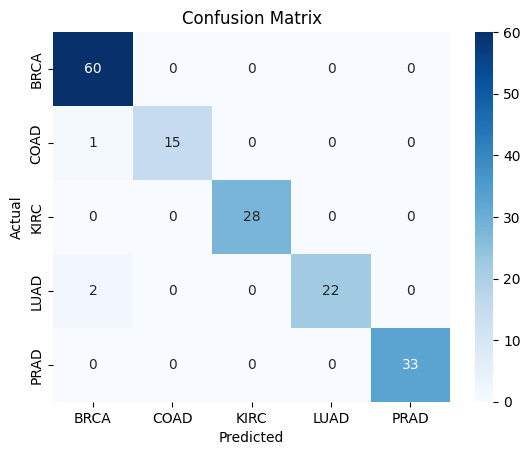

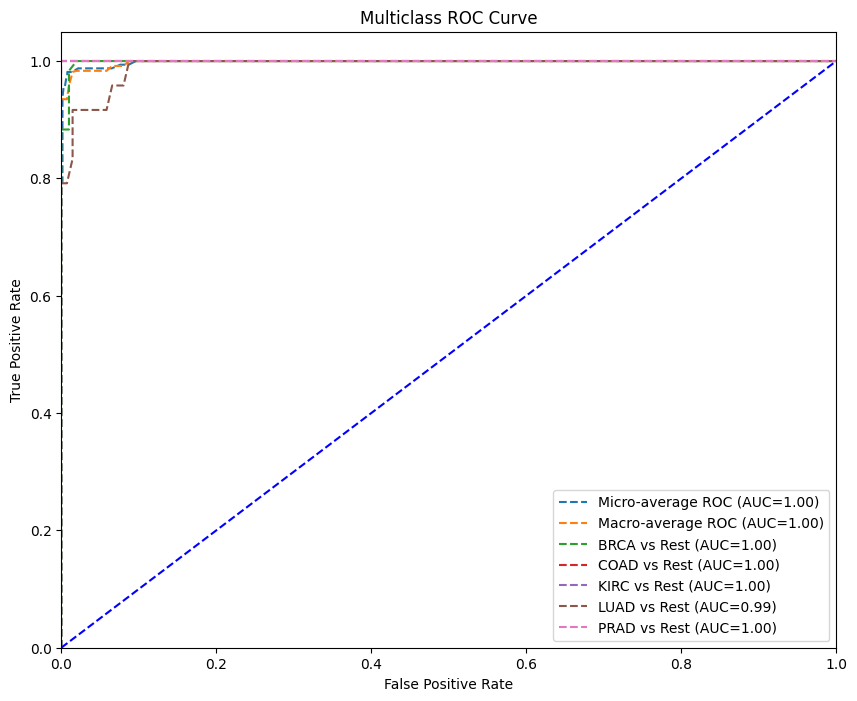

In [21]:
# Cross-Validation for Optimal Feature Selection
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_features = 0
best_cv_score = 0
cv_scores = []

# Evaluate a range of feature counts
feature_counts = [100, 200, 300, 400]  # Adjust as needed
for n_features in feature_counts:
    scores = []
    for train_idx, val_idx in cv.split(X_train_norm, y_train):
        X_train_fold, X_val_fold = X_train_norm[train_idx], X_train_norm[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Feature Selection with Mutual Information
        MI = mutual_info_classif(X_train_fold, y_train_fold)
        selected_scores_indices = np.argsort(MI)[::-1][:n_features]
        X_train_fold_selected = X_train_fold[:, selected_scores_indices]
        X_val_fold_selected = X_val_fold[:, selected_scores_indices]
        
        # Train Random Forest Model
        model = RandomForestClassifier(random_state=42)
        score = np.mean(cross_val_score(model, X_train_fold_selected, y_train_fold, cv=3, scoring='f1_weighted'))
        scores.append(score)
        
    avg_score = np.mean(scores)
    cv_scores.append((n_features, avg_score))
    if avg_score > best_cv_score:
        best_cv_score = avg_score
        best_features = n_features


print(f"Optimal feature count based on CV: {best_features} with CV Score: {best_cv_score:.4f}")

# Select final features based on optimal count
MI = mutual_info_classif(X_train_norm, y_train)
selected_scores_indices = np.argsort(MI)[::-1][:best_features]
X_train_selected = X_train_norm[:, selected_scores_indices]
X_test_selected = X_test_norm[:, selected_scores_indices]

# Model Training with GridSearchCV
params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'max_features': [0.2, 0.5, 'sqrt']}
rf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rf, params, cv=3, scoring='f1_weighted')
clf.fit(X_train_selected, y_train)
best_rf = clf.best_estimator_

# Predictions and Probabilities
y_pred = best_rf.predict(X_test_selected)
pred_prob = best_rf.predict_proba(X_test_selected)

# Performance Metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}')

# Classification Report
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

# Confusion Matrix and Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curves with Micro and Macro AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_binarized.shape[1]
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f'Micro-average ROC (AUC={roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label=f'Macro-average ROC (AUC={roc_auc["macro"]:.2f})')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{labels[i]} vs Rest (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Support Vector Machine (SVM) Classifier

Support Vector Machine (SVM) Metrics:
Accuracy: 0.9876
Precision: 0.9879
Recall: 0.9876
F1 Score: 0.9874


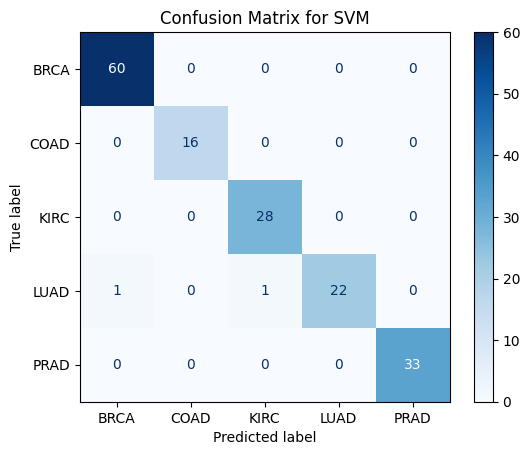

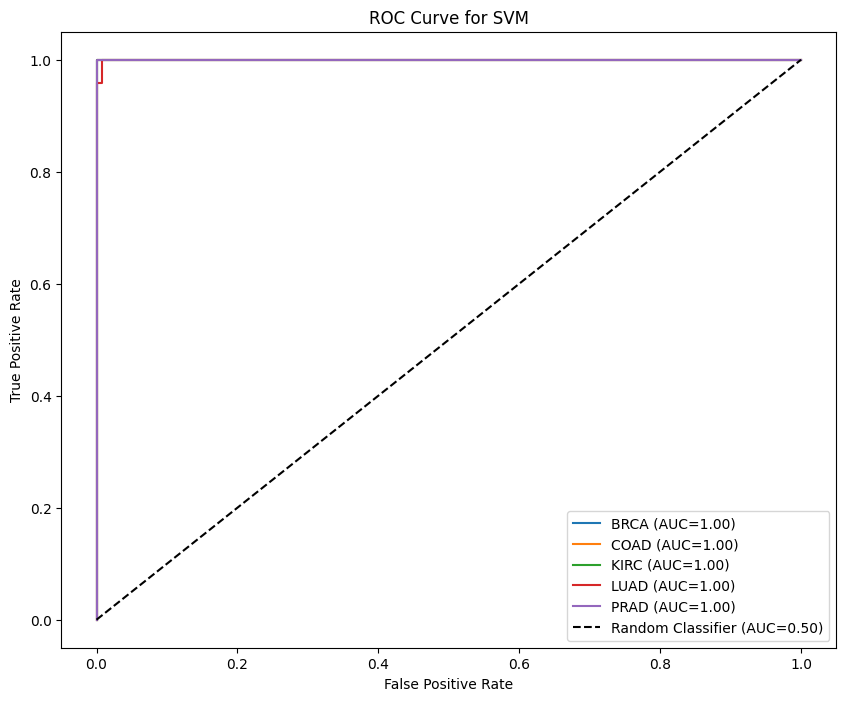

In [22]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Initialize and train the SVM model
svm_model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
svm_model.fit(X_train_selected, y_train)

# Predict and calculate probabilities
y_pred_svm = svm_model.predict(X_test_selected)
y_prob_svm = svm_model.predict_proba(X_test_selected)

# Metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Support Vector Machine (SVM) Metrics:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm, display_labels=labels).plot(cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_svm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.50)")
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# XGBoost Classifier

XGBoost Metrics:
Accuracy: 0.9689
Precision: 0.9705
Recall: 0.9689
F1 Score: 0.9687


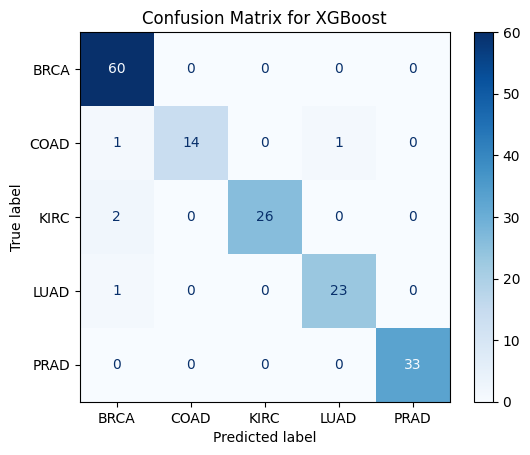

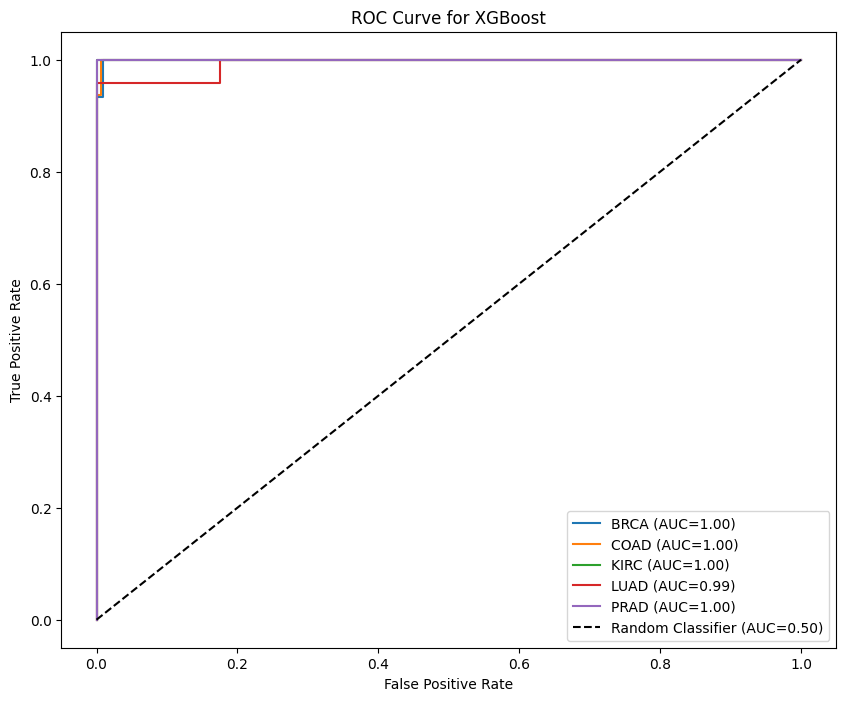

In [23]:
from xgboost import XGBClassifier

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(objective='multi:softprob', num_class=len(classes), random_state=42)
xgb_model.fit(X_train_selected, y_train)

# Predict and calculate probabilities
y_pred_xgb = xgb_model.predict(X_test_selected)
y_prob_xgb = xgb_model.predict_proba(X_test_selected)

# Metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb, display_labels=labels).plot(cmap='Blues')
plt.title("Confusion Matrix for XGBoost")
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.50)")
plt.title("ROC Curve for XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# Neural Network (MLP) Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the Neural Network (MLP) model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_selected, y_train)

# Predict and calculate probabilities
y_pred_mlp = mlp_model.predict(X_test_selected)
y_prob_mlp = mlp_model.predict_proba(X_test_selected)

# Metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

print("Neural Network (MLP) Metrics:")
print(f"Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1 Score: {f1_mlp:.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
ConfusionMatrixDisplay(cm_mlp, display_labels=labels).plot(cmap='Blues')
plt.title("Confusion Matrix for MLP")
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_mlp[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.50)")
plt.title("ROC Curve for MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# Summary Table for Metrics Comparison
After running each model’s code, you can create a table to compare the metrics:

In [ ]:
# Summary metrics comparison
results = {
    "Model": ["SVM", "XGBoost", "MLP", "Random Forest"],
    "Accuracy": [accuracy_svm, accuracy_xgb, accuracy_mlp, accuracy_rf],
    "Precision": [precision_svm, precision_xgb, precision_mlp, precision_rf],
    "Recall": [recall_svm, recall_xgb, recall_mlp, recall_rf],
    "F1 Score": [f1_svm, f1_xgb, f1_mlp, f1_rf]
}

# Convert results into DataFrame for easy visualization and comparison
results_df = pd.DataFrame(results)

# Display results
print("Model Comparison:")
print(results_df)

# Visualize results using a bar plot for each metric
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
plt.figure(figsize=(10, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=results_df, x="Model", y=metric, palette="viridis")
    plt.title(f"{metric} Comparison")
    plt.ylim(0, 1)  # Assuming metrics are scaled between 0 and 1
    plt.ylabel(metric)
    plt.xlabel("Model")

plt.tight_layout()
plt.show()


# Confusion Matrix Side-by-Side Comparison
Display each model’s confusion matrix for a clear view of the correct and 
incorrect predictions across classes.

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # Adjust to 1x4 for 4 confusion matrices
fig.suptitle("Confusion Matrix Comparison")

# SVM Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=labels, cmap="Blues", ax=axes[0])
axes[0].set_title("SVM")

# XGBoost Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=labels, cmap="Blues", ax=axes[1])
axes[1].set_title("XGBoost")

# MLP Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, display_labels=labels, cmap="Blues", ax=axes[2])
axes[2].set_title("MLP")

# Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=labels, cmap="Blues", ax=axes[3])
axes[3].set_title("Random Forest")

plt.tight_layout()
plt.show()


# ROC Curves for All Models in One Plot
Plotting all the ROC curves in a single figure allows for a quick comparison of each model's performance across each class.

In [ ]:
plt.figure(figsize=(12, 10))

# Plot ROC curves for SVM
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_svm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='--', label=f"SVM - {label} (AUC={roc_auc:.2f})")

# Plot ROC curves for XGBoost
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='-', label=f"XGBoost - {label} (AUC={roc_auc:.2f})")

# Plot ROC curves for MLP
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_mlp[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle=':', label=f"MLP - {label} (AUC={roc_auc:.2f})")

# Plot ROC curves for Random Forest
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='-.', label=f"Random Forest - {label} (AUC={roc_auc:.2f})")

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.50)")

# Set up plot aesthetics
plt.title("ROC Curves for SVM, XGBoost, MLP, and Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize="small")
plt.show()
